53561
53760
m0        = 0.0000000000
m1        = 0.0000000000
m2        = 0.0000000000
Hm0       = 0.0000000000
Tm01      = 2.5603823105
Tm02      = 0.8578357843
Tp        = 8.0000000000
fp        = 0.1255484573


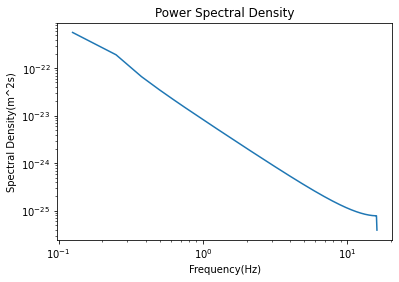

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wave_model as wm
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import scientimate as sc

#velocities are in m/s and the pressure is in decibars (1db = 104 Pa)
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()
print(len(CB_data[0]))

MV_data = np.loadtxt('data/ADV_data_MV_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
MV_data = MV_data.transpose()
print(len(MV_data[0]))

#MV: water depth is 16m
#    data was collected 0.4m above the seafloor (z = -15.6m)
#CB: water depth is 14m
#    data was collected 1.8m below the mean sea surface (z = -1.8m)
# sampling frequency of the instrument is 32Hz.
# time (dn)
# horizontal velocity (u & v)
# vertical velocity (w)
# pressure (P)

#https://oceanlyz.readthedocs.io/en/latest/python_functions/WaveSpectraFun.html
#Hm0,Tm01,Tm02,Tp,fp,f,Syy = sc.WaveSpectraFun(MV_data[0]/(1000*9.81),10,1024,256,1.07,0.05,0.05,5,1,-5,'on','on','off','on')
Hm0,Tm01,Tm02,Tp,fp,f,Syy = sc.WaveSpectraFun(input=MV_data[0],fs=32,duration=1024,nfft=256,h=16,heightfrombed=0.4,fmin=0.05,fmax=5,ftailcorrection=1,tailpower=-5,mincutoff='off',maxcutoff='off',tailcorrection='off',dispout='on')

"""
Hm0 -- Zero-Moment Wave Height (m)
Tm01 -- Wave Period from m01 (second), Mean Wave Period
Tm02 -- Wave Period from m02 (second), Mean Zero Crossing Period
Tp -- Peak Wave Period (second)
fp -- Peak Wave Frequency (Hz)
f -- Frequency (Hz)
Syy -- Wave Surface Elevation Power Spectrum (m^2s)
"""

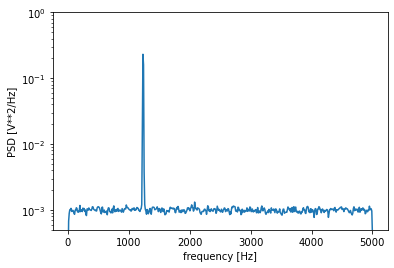

In [8]:
#example using welch function
#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html
from scipy import signal
#Generate a test signal, a 2 Vrms sine wave at 1234 Hz, corrupted by 0.001 V**2/Hz of white noise sampled at 10 kHz.
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
#Compute and plot the power spectral density.
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

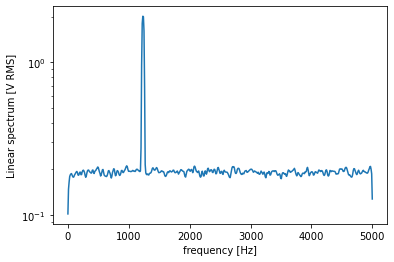

In [9]:
#If we average the last half of the spectral density, to exclude the peak, we can recover the noise power on the signal.
np.mean(Pxx_den[256:])
#Now compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

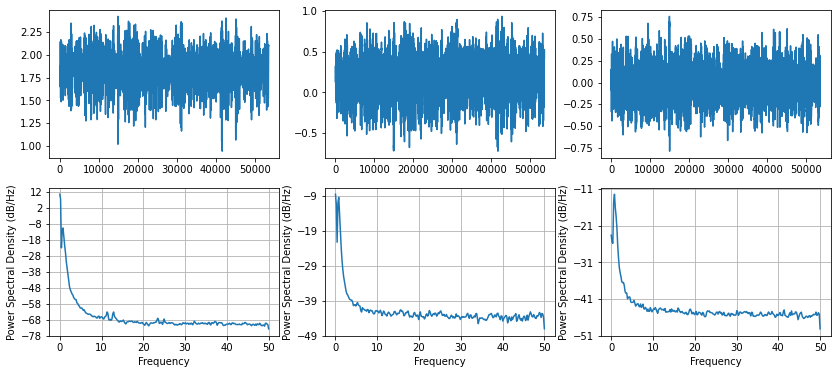

In [14]:
dt = 0.01
fig, ((ax0,ax2,ax4),(ax1,ax3,ax5)) = plt.subplots(2, 3,figsize=(14, 6))

ax0.plot(CB_data[1])
ax1.psd(CB_data[1], 512, 1 / dt)
ax2.plot(CB_data[2])
ax3.psd(CB_data[2], 512, 1 / dt)
ax4.plot(CB_data[3])
ax5.psd(CB_data[3], 512, 1 / dt)

plt.show()

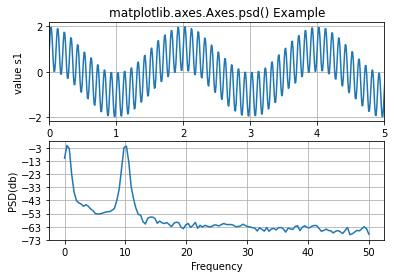

In [8]:
dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))
r = np.exp(-t / 0.05)
   
cnse1 = np.convolve(nse1, r, mode ='same')*dt
   
s1 = np.cos(np.pi * t) + cnse1 + np.sin(2 * np.pi * 10 * t) 
   
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(t, s1)
ax1.set_xlim(0, 5)
ax1.set_ylabel('value s1')
ax1.grid(True)
   
ax2.psd(s1, 256, 1./dt)
ax2.set_ylabel('PSD(db)')
ax2.set_xlabel('Frequency')
   
ax1.set_title('matplotlib.axes.Axes.psd() Example')
plt.show()

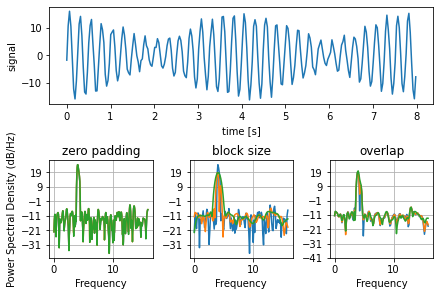

In [7]:
dt = np.pi / 100.
fs = 1. / dt
t = np.arange(0, 8, dt)
y = 10. * np.sin(2 * np.pi * 4 * t) + 5. * np.sin(2 * np.pi * 4.25 * t)
y = y + np.random.randn(*t.shape)

# Plot the raw time series
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax = fig.add_subplot(gs[0, :])
ax.plot(t, y)
ax.set_xlabel('time [s]')
ax.set_ylabel('signal')

# Plot the PSD with different amounts of zero padding. This uses the entire
# time series at once
ax2 = fig.add_subplot(gs[1, 0])
ax2.psd(y, NFFT=len(t), pad_to=len(t), Fs=fs)
ax2.psd(y, NFFT=len(t), pad_to=len(t) * 2, Fs=fs)
ax2.psd(y, NFFT=len(t), pad_to=len(t) * 4, Fs=fs)
ax2.set_title('zero padding')

# Plot the PSD with different block sizes, Zero pad to the length of the
# original data sequence.
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)
ax3.psd(y, NFFT=len(t), pad_to=len(t), Fs=fs)
ax3.psd(y, NFFT=len(t) // 2, pad_to=len(t), Fs=fs)
ax3.psd(y, NFFT=len(t) // 4, pad_to=len(t), Fs=fs)
ax3.set_ylabel('')
ax3.set_title('block size')

# Plot the PSD with different amounts of overlap between blocks
ax4 = fig.add_subplot(gs[1, 2], sharex=ax2, sharey=ax2)
ax4.psd(y, NFFT=len(t) // 2, pad_to=len(t), noverlap=0, Fs=fs)
ax4.psd(y, NFFT=len(t) // 2, pad_to=len(t),
        noverlap=int(0.05 * len(t) / 2.), Fs=fs)
ax4.psd(y, NFFT=len(t) // 2, pad_to=len(t),
        noverlap=int(0.2 * len(t) / 2.), Fs=fs)
ax4.set_ylabel('')
ax4.set_title('overlap')

plt.show()

This is a ported version of a MATLAB example from the signal
processing toolbox that showed some difference at one time between
Matplotlib's and MATLAB's scaling of the PSD.



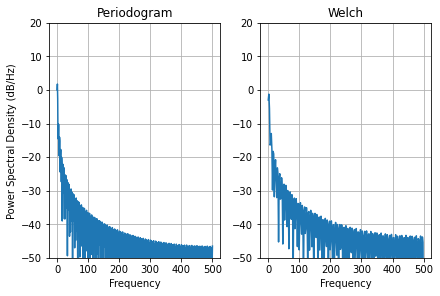

In [6]:
fs = 1000
t = np.linspace(0, 0.3, 301)
A = np.array([2, 8]).reshape(-1, 1)
f = np.array([150, 140]).reshape(-1, 1)
xn = (A * np.sin(2 * np.pi * f * t)).sum(axis=0)
xn += 5 * np.random.randn(*t.shape)

#xn = CB_data[1]

fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)

yticks = np.arange(-50, 30, 10)
yrange = (yticks[0], yticks[-1])
xticks = np.arange(0, 550, 100)

ax0.psd(xn, NFFT=301, Fs=fs, window=mlab.window_none, pad_to=1024,
        scale_by_freq=True)
ax0.set_title('Periodogram')
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(True)
ax0.set_ylim(yrange)

ax1.psd(xn, NFFT=150, Fs=fs, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
ax1.set_title('Welch')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
ax1.set_ylim(yrange)

plt.show()

This is a ported version of a MATLAB example from the signal
processing toolbox that showed some difference at one time between
Matplotlib's and MATLAB's scaling of the PSD.

It uses a complex signal so we can see that complex PSD's work properly.



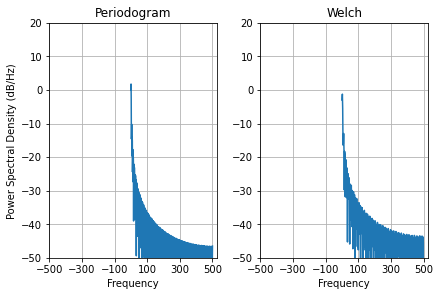

In [17]:
prng = np.random.RandomState(19680801)  # to ensure reproducibility

fs = 1000
t = np.linspace(0, 0.3, 301)
A = np.array([2, 8]).reshape(-1, 1)
f = np.array([150, 140]).reshape(-1, 1)
xn = (A * np.exp(2j * np.pi * f * t)).sum(axis=0) + 5 * prng.randn(*t.shape)

#xn = CB_data[1]


fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)

yticks = np.arange(-50, 30, 10)
yrange = (yticks[0], yticks[-1])
xticks = np.arange(-500, 550, 200)

ax0.psd(xn, NFFT=301, Fs=fs, window=mlab.window_none, pad_to=1024,
        scale_by_freq=True)
ax0.set_title('Periodogram')
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(True)
ax0.set_ylim(yrange)

ax1.psd(xn, NFFT=150, Fs=fs, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
ax1.set_title('Welch')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
ax1.set_ylim(yrange)

plt.show()